In [17]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy import stats

from sklearn.preprocessing import OrdinalEncoder, KBinsDiscretizer
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import lightgbm as lgb
import optuna

In [2]:
# loading the train labels

labels_df = pd.read_csv('train_labels.csv')

labels_df['session'] = labels_df['session_id'].apply(lambda x: int(x.split('_')[0]))
labels_df['question'] = labels_df['session_id'].apply(lambda x: int(x.split('q')[1]))

labels_df = (
    labels_df
    .sort_values(by=['session', 'question'], ascending=[True, True])
    .reindex(columns=['session_id', 'session', 'question', 'correct'])
    .reset_index(drop=True)
    .drop(columns='session_id')
)

labels_df.head()

,session,question,correct
0,20090312431273200,1,1
1,20090312431273200,2,1
2,20090312431273200,3,1
3,20090312431273200,4,1
4,20090312431273200,5,1


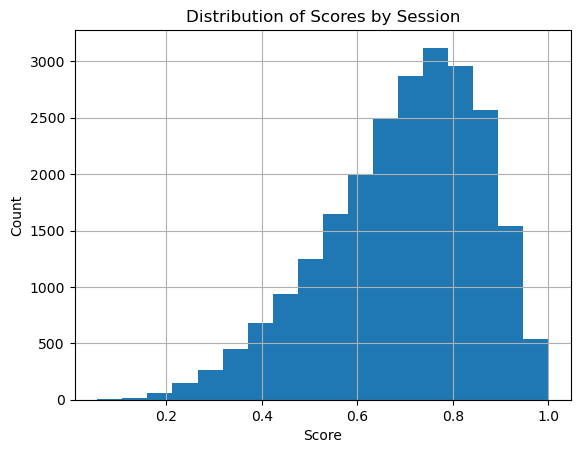

In [3]:
# the distribution of scores. it's almost definitely
# true that adding predictions from prior rounds
# will improve the model significantly. 

labels_df.groupby('session')['correct'].mean().hist(bins=18)

plt.title("Distribution of Scores by Session")

plt.ylabel("Count")
plt.xlabel("Score")

plt.show()

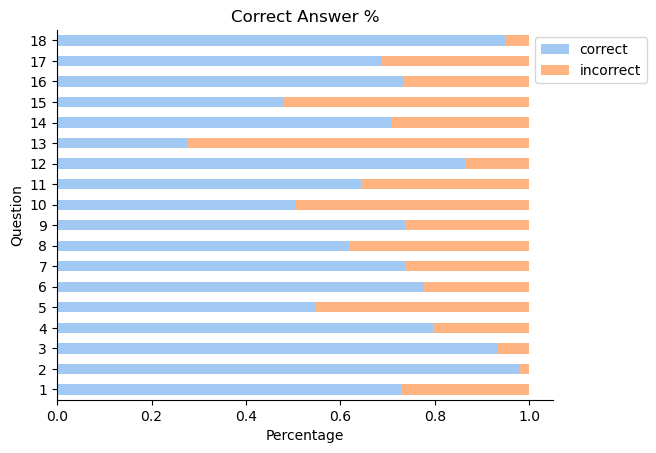

In [4]:
# calculating mean correct responses for each question
q_accuracy_df = labels_df.groupby('question')['correct'].mean().to_frame()
q_accuracy_df['incorrect'] = 1 - q_accuracy_df

# plotting the correct answer % by question
colors = sns.color_palette("pastel")

# horizontal barplot in seaborn with no spines
ax = q_accuracy_df.plot(kind='barh', stacked=True, color=colors, legend=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Correct Answer %")
plt.xlabel("Percentage")
plt.ylabel("Question")

legend = plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left')
plt.show()

In [5]:
# excluding cols to save memory
exclude_cols = ['index', 'fullscreen', 'hq', 'music']

# borrowing the dtypes dictionary from a featured notebook
dtypes = {
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text': 'category',
    'fqid': 'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen': bool,
    'hq':bool,
    'music': bool,
    'level_group':'category'
}

df = pd.read_csv('train.csv', usecols=lambda x: x not in exclude_cols, dtype=dtypes)

df = (
    df
    .sort_values(by=['session_id', 'level', 'elapsed_time'], ascending=[True, True, True])
    .reset_index(drop=True)
)

In [8]:
def prep_data(level_group=None):
    "prepping the data for the submission"
    
    level_dict = {
        '0-4' : [1, 2, 3],
        '5-12' : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        '13-22' : [14, 15, 16, 17, 18]
    }

    
    df_ = df[df['level_group'] == level_group].copy()
    
    # getting elapsed diffs
    df_['event_time_delta'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: x.diff().fillna(0))
        .clip(0, 103000) 
    )

    # getting the time until the next event
    df_['time_delta_til_next'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: abs(x.diff(-1)).fillna(0))
        .clip(0, 103000)
    )
    
    
    # time delta means    
    time_delta_mean = df_.groupby('session_id').agg(event_time_mean=('event_time_delta', 'mean'),
                                                    event_time_std=('event_time_delta', 'std'),
                                                    event_time_max=('event_time_delta', 'max'))
    
    # hover duration stats
    hover_duration = df_.groupby('session_id').agg(hover_duration_mean=('hover_duration', 'mean'),
                                                        hover_duration_std=('hover_duration', 'std'),
                                                        hover_duration_max=('hover_duration', 'max'))
    
    # total time on each event
    total_time_event = (
        df_
        .groupby(['session_id', 'event_name'])
        .agg(total_time_event=('time_delta_til_next', 'sum'),
             mean_time_event=('time_delta_til_next', 'mean'),
             std_time_event=('time_delta_til_next', 'std'))
        .unstack()
    )
    
    # total time on text_id
    total_time_text = (
        df_
        .groupby(['session_id', 'text_fqid'])['event_time_delta']
        .sum()
        .unstack()
        .rename(columns=lambda x: f"time_on_{x}")
    )
    
    # total time on each level    
    level_duration = (
        df_
        .groupby(['session_id', 'level'])['elapsed_time']
        .apply(lambda x: x.max() - x.min())
        .unstack()
        .rename(columns=lambda x: f'time_on_level_{x}')
    )
    
    # page counts
    page_counts = df_.groupby('session_id')['page'].value_counts().unstack().fillna(0)
    page_counts.columns = [f'page_{x}' for x in page_counts.columns]
    
    # unique rooms
    nunique_rooms = (
        df_
        .groupby(['session_id', 'level'])['room_fqid']
        .nunique()
        .unstack()
        .rename(columns=lambda x: f'unique_room_fqid_level_{x}')
    )
    
    # unique text ids
    nunique_text_ids = (
        df_
        .groupby(['session_id', 'level'])['text_fqid']
        .nunique()
        .unstack()
        .rename(columns=lambda x: f'unique_text_fqid_level_{x}')
    )
    
    # unique fqids 
    nunique_fqid = (
        df_
        .groupby(['session_id', 'level'])['fqid']
        .nunique()
        .unstack()
        .rename(columns=lambda x: f'unique_fqid_level_{x}')
    )
    
    # how many events of each type occurred in the session
    event_counts = df_.groupby('session_id')['event_name'].value_counts().unstack()
    
    # getting session lengths
    session_lengths = df_.groupby('session_id')['elapsed_time'].max().rename('total_length')
    
    # total events in the session
    session_events = df_.groupby('session_id')['session_id'].count()
    
    # final df pre labels
    df_features = (
        pd.concat([total_time_event, nunique_text_ids, nunique_fqid, event_counts, 
                   session_lengths, session_events, time_delta_mean, hover_duration,
                   level_duration, page_counts, total_time_text], axis=1)
        .fillna(0)
        .drop(columns='session_id')
        .reset_index()
    )
    
    # fixing column names 
    df_features.rename(columns=lambda x: '_'.join(x) if isinstance(x, tuple) else x, inplace=True)
    
    return df_features.set_index('session_id')

In [9]:
# creating these df to speed up training
# originally i had it setup so it could be replicated
# (including model training) in a kaggle notebook with a 
# very limited memory, but i need to improve the model
# and i'm trying out a few things
group1_df = prep_data('0-4')
group2_df = prep_data('5-12')
group3_df = prep_data('13-22')

print("the shape of the three dfs is:", group1_df.shape, group2_df.shape, group3_df.shape)

In [ ]:
# cleaned up the modelling loop after getting more experience
# using oof predictions, lgbm, and so on. we're also using
# stratified kfold instead of stratified groupkfold
# because we don't need to keep session proportions equal

lgb_oof = labels_df.set_index('session')
lgb_oof['oof_pred'] = 0

models = {}

for question in range(1, 19):
    
    if question in [1, 2, 3, 4]:
        X = group1_df.copy()
    
    elif question in [5, 6, 7, 8, 9, 10, 11, 12, 13]:
        X = group2_df.copy()
    
    else:
        X = group3_df.copy()
        
        
    X_sessions = X.index    
    y = labels_df[labels_df['question'] == question].set_index('session').loc[X_sessions]['correct']
    
    str_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=9)
    question_oof = np.zeros(len(X))
        
    for i, (train, val) in enumerate(str_kfold.split(X, y)):
        
        train_x = X.iloc[train].values
        train_y = y.iloc[train]
        
        val_x = X.iloc[val].values
        val_y = y.iloc[val]
        
        # defining the lgbm parameters that work best
        lgbm_params = {
            'learning_rate' : 0.006,
            'num_boost_round' : 1000,
            'boosting_type' : 'gbdt',
            'objective' : 'binary',
            'alpha' : 8,
            'max_depth' : 25,
            'subsample' : 0.9,
            'colsample_bytree' : 0.5
        }
        
        # defining and fitting the model
        lgbm_model = lgb.LGBMClassifier(**lgbm_params)        
        lgbm_model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=15)
        
        # getting the predictions
        preds = lgbm_model.predict_proba(val_x)[:,1]
        
        # adding the predictions to the out of fold array for this q
        question_oof[val] = preds
        
        models[f'question_{question}_{i}'] = lgbm_model
    
    # adding each question's oof array to the oof dataframe
    lgb_oof.loc[lgb_oof['question'] == question, 'oof_preds'] = question_oof

In [57]:
# iterating over classifier thresholds to find the
# value that maximizes f1_score with average='macro'

# lists for scores and thresholds
scores = []
thresholds = []

best_score = 0
best_threshold = 0

# iterate over all the possible thresholds
for threshold in np.arange(0.4, 0.81, 0.01):    
    
    # get the preds
    preds =  (lgb_oof['oof_preds'] > threshold).astype(int)
    
    # used a cleaner way of keeping the oof preds
    m = f1_score(lgb_oof['correct'],
                 preds,
                 average='macro')
    
    # appending to the dataframe
    scores.append(m)
    thresholds.append(threshold)
    
    # only change em if they exceed highest value so far
    if m > best_score:
        best_score = m
        best_threshold = threshold

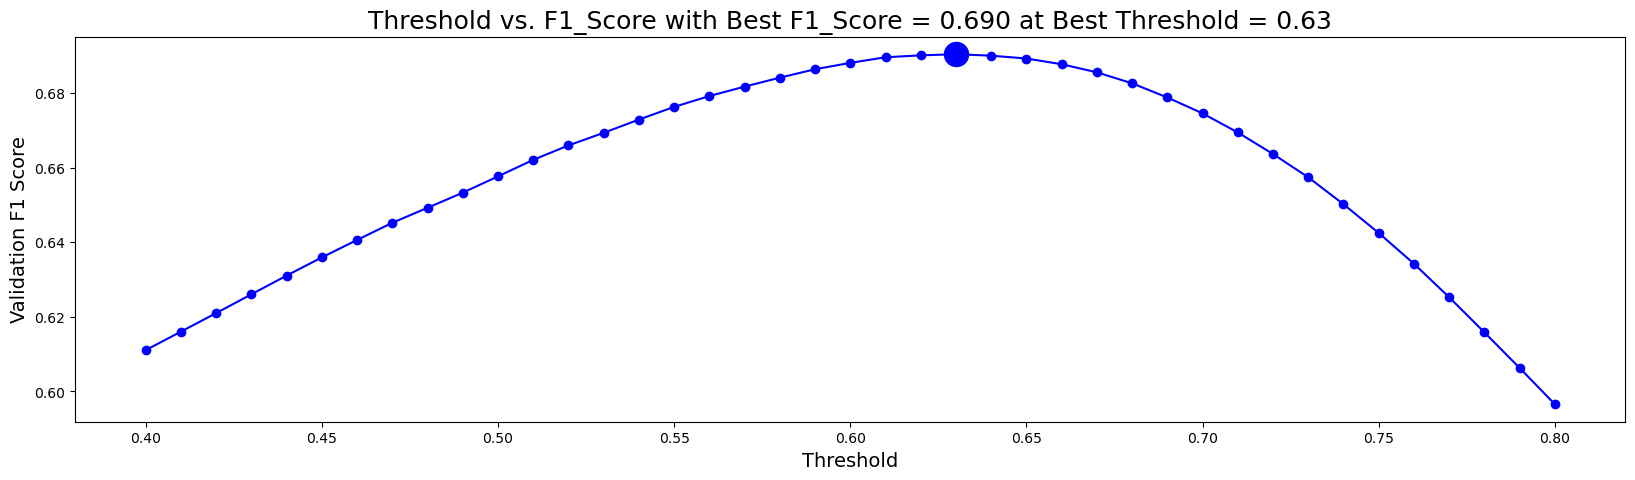

In [58]:
# stealing a plot from another person, but it looks nice

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, "-o", color="blue")
plt.scatter([best_threshold], [best_score], color="blue", s=300, alpha=1)
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score", size=14)
plt.title(
    f"Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}",
    size=18,
)
plt.show()

In [14]:
def kaggle_prep(test_data=None):
    "prepping the data for the kaggle notebook"
    
    level_dict = {
        '0-4' : [1, 2, 3],
        '5-12' : [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        '13-22' : [14, 15, 16, 17, 18]
    }

    
    df_ = test_data.copy()
   
    # getting elapsed diffs
    df_['event_time_delta'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: x.diff().fillna(0))
        .clip(0, 103000) 
    )

    # getting the time until the next event
    df_['time_delta_til_next'] = (
        df_
        .groupby('session_id')['elapsed_time']
        .transform(lambda x: abs(x.diff(-1)).fillna(0))
        .clip(0, 103000)
    )
    
    
    # time delta means    
    time_delta_mean = df_.groupby('session_id').agg(event_time_mean=('event_time_delta', 'mean'),
                                                    event_time_std=('event_time_delta', 'std'),
                                                    event_time_max=('event_time_delta', 'max'))
    
    # hover duration stats
    hover_duration = df_.groupby('session_id').agg(hover_duration_mean=('hover_duration', 'mean'),
                                                        hover_duration_std=('hover_duration', 'std'),
                                                        hover_duration_max=('hover_duration', 'max'))
    
    # total time on each event
    total_time_event = (
        df_
        .groupby(['session_id', 'event_name'])
        .agg(total_time_event=('time_delta_til_next', 'sum'),
             mean_time_event=('time_delta_til_next', 'mean'),
             std_time_event=('time_delta_til_next', 'std'))
        .unstack()
    )
    
    # total time on text_id
    total_time_text = (
        df_
        .groupby(['session_id', 'text_fqid'])['event_time_delta']
        .sum()
        .unstack()
        .rename(columns=lambda x: f"time_on_{x}")
    )
    
    # total time on each level    
    level_duration = (
        df_
        .groupby(['session_id', 'level'])['elapsed_time']
        .apply(lambda x: x.max() - x.min())
        .unstack()
        .rename(columns=lambda x: f'time_on_level_{x}')
    )
    
    # page counts
    page_counts = df_.groupby('session_id')['page'].value_counts().unstack().fillna(0)
    page_counts.columns = [f'page_{x}' for x in page_counts.columns]
    
    # unique rooms
    nunique_rooms = (
        df_
        .groupby(['session_id', 'level'])['room_fqid']
        .nunique()
        .unstack()
        .rename(columns=lambda x: f'unique_room_fqid_level_{x}')
    )
    
    # unique text ids
    nunique_text_ids = (
        df_
        .groupby(['session_id', 'level'])['text_fqid']
        .nunique()
        .unstack()
        .rename(columns=lambda x: f'unique_text_fqid_level_{x}')
    )
    
    # unique fqids 
    nunique_fqid = (
        df_
        .groupby(['session_id', 'level'])['fqid']
        .nunique()
        .unstack()
        .rename(columns=lambda x: f'unique_fqid_level_{x}')
    )
    
    # how many events of each type occurred in the session
    event_counts = df_.groupby('session_id')['event_name'].value_counts().unstack()
    
    # getting session lengths
    session_lengths = df_.groupby('session_id')['elapsed_time'].max().rename('total_length')
    
    # total events in the session
    session_events = df_.groupby('session_id')['session_id'].count()
    
    # final df pre labels
    df_features = (
        pd.concat([total_time_event, nunique_text_ids, nunique_fqid, event_counts, 
                   session_lengths, session_events, time_delta_mean, hover_duration,
                   level_duration, page_counts, total_time_text], axis=1)
        .fillna(0)
        .drop(columns='session_id')
        .reset_index()
    )
    
    # fixing column names 
    df_features.rename(columns=lambda x: '_'.join(x) if isinstance(x, tuple) else x, inplace=True)
    
    return df_features.set_index('session_id')

In [210]:
# saving models
for key in models.keys():
    
    if 'fold_3' in key:
    
        model_ = models[key]
    
        with open(f'models/{key}.pickle', 'wb') as file:
            pickle.dump(model_, file, protocol=4)

In [245]:
# saving models with session histories

for key in models.keys():
    
    if 'fold_4' in key:
        model_ = models[key]
        
        with open(f'models/session_{key}.pickle', 'wb') as file:
            pickle.dump(model_, file, protocol=4)

In [247]:
# loading models for test

loaded_models = {}

for filename in os.listdir('models'):
    if 'fold_3' in filename:
        with open(f'models/{filename}', 'rb') as file:
            name = filename.split('.')[0]
            model_ = pickle.load(file)
            loaded_models[name] = model_

In [251]:
# this cell iterates over the test data 
test_df = pd.read_csv('test.csv')

# col_to_drop = np.random.choice(test_df.columns, 2, replace=False)
# test_df = test_df.drop(columns=col_to_drop)

# defining the questions for each group
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for _, tf in test_df.groupby(['session_id', 'level_group']):
    
    # get the level group (to get the data for the model)
    level_group = tf['level_group'].values[0]
    
    # create feature test_df
    test_df_ = kaggle_prep(tf)
    session = test_df_.index.values[0]
    print(test_df)
    
    # get the questions to iterate over
    a, b = limits[level_group]
    
    for question in range(a, b):
        # getting model and threshold for the question
        model_ = models[f'question_{question}_fold_4']
        feature_names = model_.feature_name_
        threshold = 0.63
        
#         if question > 1:
#             for n in range(1, question):
#                 try:
#                     test_df_[f'{question-1}_result'] = nested_dict[session][question - 1]
#                 except:
#                     print(question, session, "exception")
#                     test_df_[f'{question-1}_result'] = base_rate_dict[question - 1]
        
        # figure out if feature columns are missing - important for submission
        missing_columns = list(set(feature_names) - set(test_df_.columns))
        
        # create a dataframe with the missing columns filled with 0s (for now)
        missing_test_df = pd.DataFrame(0, columns=missing_columns, index=test_df_.index)

        # combine the original test_df and the missing test_df
        test_df_ = pd.concat([test_df_, missing_test_df], axis=1)

        raw_pred_proba = model_.predict_proba(test_df_[feature_names])[0, 1]
        final_pred = (raw_pred_proba > threshold).astype(int)
    
        print(final_pred)
        
#         if session not in nested_dict:
#             nested_dict[session] = {}
#             nested_dict[session][question] = final_pred
#         else:
#             nested_dict[session][question] = final_pred

             session_id  index  elapsed_time      event_name       name  \
0     20090109393214576      0             0  cutscene_click      basic   
1     20090109393214576      1          1965    person_click      basic   
2     20090109393214576      2          3614    person_click      basic   
3     20090109393214576      3          5330    person_click      basic   
4     20090109393214576      4          6397    person_click      basic   
...                 ...    ...           ...             ...        ...   
3723  20090312331414616   1001       1581679       map_hover      basic   
3724  20090312331414616   1002       1583044       map_hover      basic   
3725  20090312331414616   1003       1583410       map_click  undefined   
3726  20090312331414616   1004       1585841  navigate_click  undefined   
3727  20090312331414616   1005       1587810      checkpoint      basic   

      level  page  room_coor_x  room_coor_y  screen_coor_x  ...  \
0         0   NaN  -413.991405  

             session_id  index  elapsed_time      event_name       name  \
0     20090109393214576      0             0  cutscene_click      basic   
1     20090109393214576      1          1965    person_click      basic   
2     20090109393214576      2          3614    person_click      basic   
3     20090109393214576      3          5330    person_click      basic   
4     20090109393214576      4          6397    person_click      basic   
...                 ...    ...           ...             ...        ...   
3723  20090312331414616   1001       1581679       map_hover      basic   
3724  20090312331414616   1002       1583044       map_hover      basic   
3725  20090312331414616   1003       1583410       map_click  undefined   
3726  20090312331414616   1004       1585841  navigate_click  undefined   
3727  20090312331414616   1005       1587810      checkpoint      basic   

      level  page  room_coor_x  room_coor_y  screen_coor_x  ...  \
0         0   NaN  -413.991405  

             session_id  index  elapsed_time      event_name       name  \
0     20090109393214576      0             0  cutscene_click      basic   
1     20090109393214576      1          1965    person_click      basic   
2     20090109393214576      2          3614    person_click      basic   
3     20090109393214576      3          5330    person_click      basic   
4     20090109393214576      4          6397    person_click      basic   
...                 ...    ...           ...             ...        ...   
3723  20090312331414616   1001       1581679       map_hover      basic   
3724  20090312331414616   1002       1583044       map_hover      basic   
3725  20090312331414616   1003       1583410       map_click  undefined   
3726  20090312331414616   1004       1585841  navigate_click  undefined   
3727  20090312331414616   1005       1587810      checkpoint      basic   

      level  page  room_coor_x  room_coor_y  screen_coor_x  ...  \
0         0   NaN  -413.991405  

In [145]:
with open('base_rate_dict.pickle', 'wb') as file:
    pickle.dump(base_rate_dict, file, protocol=4)